# EDA

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

In [57]:
def value_counts_ratio(df, col_name, target_name='target'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

In [6]:
# csv 불러오기
train_data = pd.read_csv('trim_train_data.csv')

In [7]:
# info 잘리지 않게 출력
train_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 464 columns):
 #    Column                                                      Dtype  
---   ------                                                      -----  
 0    Wip Line_Dam                                                object 
 1    Process Desc._Dam                                           object 
 2    Equipment_Dam                                               object 
 3    Model.Suffix_Dam                                            object 
 4    Workorder_Dam                                               object 
 5    Insp. Seq No._Dam                                           int64  
 6    Insp Judge Code_Dam                                         object 
 7    CURE END POSITION X Collect Result_Dam                      float64
 8    CURE END POSITION X Unit Time_Dam                           float64
 9    CURE END POSITION X Judge Value_Dam                         float64
 1

### 1. 변수 간 관계 확인

#### Chamber Temp. Judge value & Chamber temp

In [15]:
train_data['Chamber Temp. Judge Value_AutoClave'].value_counts()

Chamber Temp. Judge Value_AutoClave
OK    29112
NG    11394
Name: count, dtype: int64

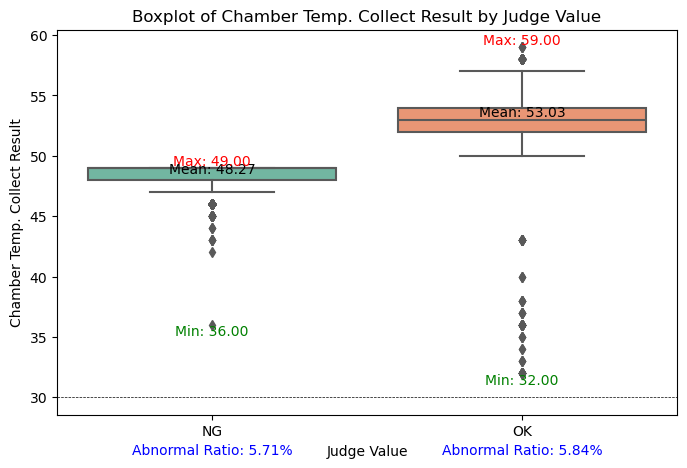

In [27]:
# OK와 NG 각각의 abnormal 비율 계산
abnormal_ratios = train_data.groupby('Chamber Temp. Judge Value_AutoClave')['target'].apply(lambda x: (x == 'AbNormal').mean()).reset_index()
abnormal_ratios.columns = ['Chamber Temp. Judge Value_AutoClave', 'Abnormal Ratio']

# 시각화
plt.figure(figsize=(8, 5))

# 박스 플롯 생성 (x축 순서 지정)
order = ['NG', 'OK']  # 원하는 순서로 지정
sns.boxplot(x='Chamber Temp. Judge Value_AutoClave', y='Chamber Temp. Collect Result_AutoClave', data=train_data, palette='Set2', order=order)

# 각 박스의 중앙값, 최대값, 최소값 표시
summary = train_data.groupby('Chamber Temp. Judge Value_AutoClave')['Chamber Temp. Collect Result_AutoClave'].agg(['mean', 'max', 'min']).reset_index()

for index, row in summary.iterrows():
    # 중앙값 표시 (박스의 중앙 위치)
    plt.text(index, row['mean'], f"Mean: {row['mean']:.2f}", color='black', ha='center', va='bottom')
    # 최대값 표시 (박스 위쪽)
    plt.text(index, row['max'], f"Max: {row['max']:.2f}", color='red', ha='center', va='bottom')
    # 최소값 표시 (박스 아래쪽)
    plt.text(index, row['min'], f"Min: {row['min']:.2f}", color='green', ha='center', va='top')

# abnormal 비율 표시
for index, row in abnormal_ratios.iterrows():
    plt.text(index, 25, f"Abnormal Ratio: {row['Abnormal Ratio']:.2%}", color='blue', ha='center', va='bottom')

plt.title('Boxplot of Chamber Temp. Collect Result by Judge Value')
plt.xlabel('Judge Value')
plt.ylabel('Chamber Temp. Collect Result')
plt.axhline(30, color='black', linewidth=0.5, ls='--')
plt.show()

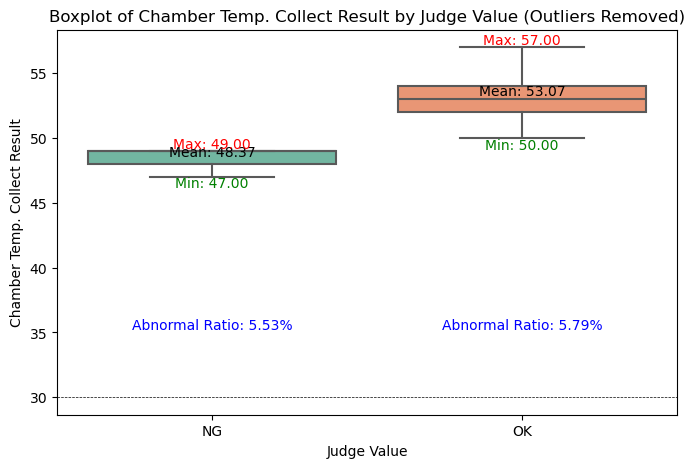

In [29]:
# OK와 NG 각각의 데이터 준비
ok_data = train_data[train_data['Chamber Temp. Judge Value_AutoClave'] == 'OK']['Chamber Temp. Collect Result_AutoClave']
ng_data = train_data[train_data['Chamber Temp. Judge Value_AutoClave'] == 'NG']['Chamber Temp. Collect Result_AutoClave']

# IQR 계산
def remove_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

# 이상치 제거
clean_ok_data = remove_outliers(ok_data)
clean_ng_data = remove_outliers(ng_data)

# 이상치 제거된 데이터프레임 생성
cleaned_train_data = train_data[
    (train_data['Chamber Temp. Judge Value_AutoClave'] == 'OK') & 
    (train_data['Chamber Temp. Collect Result_AutoClave'].isin(clean_ok_data)) |
    (train_data['Chamber Temp. Judge Value_AutoClave'] == 'NG') & 
    (train_data['Chamber Temp. Collect Result_AutoClave'].isin(clean_ng_data))
]

# OK와 NG 각각의 abnormal 비율 계산
abnormal_ratios = cleaned_train_data.groupby('Chamber Temp. Judge Value_AutoClave')['target'].apply(lambda x: (x == 'AbNormal').mean()).reset_index()
abnormal_ratios.columns = ['Chamber Temp. Judge Value_AutoClave', 'Abnormal Ratio']

# 시각화
plt.figure(figsize=(8, 5))

# 박스 플롯 생성 (이상치 제거 후)
order = ['NG', 'OK']  # 원하는 순서로 지정
sns.boxplot(x='Chamber Temp. Judge Value_AutoClave', y='Chamber Temp. Collect Result_AutoClave', data=cleaned_train_data, palette='Set2', order=order)

# 각 박스의 평균, 최대값, 최소값 표시
summary = cleaned_train_data.groupby('Chamber Temp. Judge Value_AutoClave')['Chamber Temp. Collect Result_AutoClave'].agg(['mean', 'max', 'min']).reset_index()

for index, row in summary.iterrows():
    # 평균 표시 (박스의 중앙 위치)
    plt.text(index, row['mean'], f"Mean: {row['mean']:.2f}", color='black', ha='center', va='bottom')
    # 최대값 표시 (박스 위쪽)
    plt.text(index, row['max'], f"Max: {row['max']:.2f}", color='red', ha='center', va='bottom')
    # 최소값 표시 (박스 아래쪽)
    plt.text(index, row['min'], f"Min: {row['min']:.2f}", color='green', ha='center', va='top')

# abnormal 비율 표시
for index, row in abnormal_ratios.iterrows():
    plt.text(index, 35, f"Abnormal Ratio: {row['Abnormal Ratio']:.2%}", color='blue', ha='center', va='bottom')

plt.title('Boxplot of Chamber Temp. Collect Result by Judge Value (Outliers Removed)')
plt.xlabel('Judge Value')
plt.ylabel('Chamber Temp. Collect Result')
plt.axhline(30, color='black', linewidth=0.5, ls='--')
plt.show()

-> 이상치를 제거하고 봐도 NG와 OK 값이 abnormal 비율과 관련있어보이지는 않음. 대신 NG의 경우 chamber temp가 OK를 받았을 때보다 확연히 낮음.

### 2. circle, line 변수 처리

- circle 데이터 확인

In [41]:
### stage1 circle1~4
columns_to_check = [
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Circle3 Distance Speed Collect Result_Dam',
    'Stage1 Circle4 Distance Speed Collect Result_Dam',
]

# 모든 행에서 4개의 컬럼 값이 동일한지 확인
train_data['all_equal'] = train_data[columns_to_check].apply(lambda row: row.nunique() == 1, axis=1)

# 동일한 행의 수 세기
num_equal_rows = train_data['all_equal'].sum()

# 결과 출력
if num_equal_rows > 0:
    print(f"{num_equal_rows}개의 행에서 모든 변수의 값이 동일합니다.")

40506개의 행에서 모든 변수의 값이 동일합니다.


In [42]:
### stage2 circle1~4
columns_to_check = [
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Circle3 Distance Speed Collect Result_Dam',
    'Stage2 Circle4 Distance Speed Collect Result_Dam'
]

# 모든 행에서 4개의 컬럼 값이 동일한지 확인
train_data['all_equal'] = train_data[columns_to_check].apply(lambda row: row.nunique() == 1, axis=1)

# 동일한 행의 수 세기
num_equal_rows = train_data['all_equal'].sum()

# 결과 출력
if num_equal_rows > 0:
    print(f"{num_equal_rows}개의 행에서 모든 변수의 값이 동일합니다.")

40506개의 행에서 모든 변수의 값이 동일합니다.


In [63]:
### stage3 circle1~4
columns_to_check = [
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Circle3 Distance Speed Collect Result_Dam',
    'Stage3 Circle4 Distance Speed Collect Result_Dam'
]

# 모든 행에서 4개의 컬럼 값이 동일한지 확인
train_data['all_equal'] = train_data[columns_to_check].apply(lambda row: row.nunique() == 1, axis=1)

# 동일한 행의 수 세기
num_equal_rows = train_data['all_equal'].sum()

# 결과 출력
if num_equal_rows > 0:
    print(f"{num_equal_rows}개의 행에서 모든 변수의 값이 동일합니다.")

40506개의 행에서 모든 변수의 값이 동일합니다.


-> 각각의 stage 모두 circle1~4 값이 동일함. 각각 stage 별로 circle 값은 하나씩 사용하면 될듯. (stage끼리는 circle 값이 동일하지 않음)

- line 데이터 확인

In [76]:
### stage1 (같으면 그 값, 다르면 diff)
# line 1 & 3
train_data['stage1_line13_distance_speed_Dam'] = train_data.apply(
    lambda row: row['Stage1 Line1 Distance Speed Collect Result_Dam'] 
    if (row['Stage1 Line1 Distance Speed Collect Result_Dam'] == 
        row['Stage1 Line3 Distance Speed Collect Result_Dam']) else 'diff', axis=1)
# line 2 & 4
train_data['stage1_line24_distance_speed_Dam'] = train_data.apply(
    lambda row: row['Stage1 Line2 Distance Speed Collect Result_Dam'] 
    if (row['Stage1 Line2 Distance Speed Collect Result_Dam'] == 
        row['Stage1 Line4 Distance Speed Collect Result_Dam']) else 'diff', axis=1)

### stage2 (같으면 그 값, 다르면 diff)
# line 1 & 3
train_data['stage2_line13_distance_speed_Dam'] = train_data.apply(
    lambda row: row['Stage2 Line1 Distance Speed Collect Result_Dam'] 
    if (row['Stage2 Line1 Distance Speed Collect Result_Dam'] == 
        row['Stage2 Line3 Distance Speed Collect Result_Dam']) else 'diff', axis=1)
# line 2 & 4
train_data['stage2_line24_distance_speed_Dam'] = train_data.apply(
    lambda row: row['Stage2 Line2 Distance Speed Collect Result_Dam'] 
    if (row['Stage2 Line2 Distance Speed Collect Result_Dam'] == 
        row['Stage2 Line4 Distance Speed Collect Result_Dam']) else 'diff', axis=1)

### stage3 (같으면 그 값, 다르면 diff)
# line 1 & 3
train_data['stage3_line13_distance_speed_Dam'] = train_data.apply(
    lambda row: row['Stage3 Line1 Distance Speed Collect Result_Dam'] 
    if (row['Stage3 Line1 Distance Speed Collect Result_Dam'] == 
        row['Stage3 Line3 Distance Speed Collect Result_Dam']) else 'diff', axis=1)
# line 2 & 4
train_data['stage3_line24_distance_speed_Dam'] = train_data.apply(
    lambda row: row['Stage3 Line2 Distance Speed Collect Result_Dam'] 
    if (row['Stage3 Line2 Distance Speed Collect Result_Dam'] == 
        row['Stage3 Line4 Distance Speed Collect Result_Dam']) else 'diff', axis=1)

In [79]:
# 변수 리스트
variables = [
    'stage1_line13_distance_speed_Dam',
    'stage1_line24_distance_speed_Dam',
    
    'stage2_line13_distance_speed_Dam',
    'stage2_line24_distance_speed_Dam',

    'stage3_line13_distance_speed_Dam',
    'stage3_line24_distance_speed_Dam'
]

# 각 변수에 대해 타겟 변수의 고유값 비율과 개수 계산
for var in variables:
    # 각 변수의 고유값에 따른 타겟 변수의 비율 및 개수 계산
    target_distribution = train_data.groupby(var)['target'].value_counts(normalize=True).unstack(fill_value=0)
    target_counts = train_data.groupby(var)['target'].value_counts().unstack(fill_value=0)
    
    # 결과 출력
    print(f"{var}에 따른 타겟 변수의 비율 및 개수:")
    print("비율:\n", target_distribution)
    print("개수:\n", target_counts)
    print("\n")

stage1_line13_distance_speed_Dam에 따른 타겟 변수의 비율 및 개수:
비율:
 target                            AbNormal    Normal
stage1_line13_distance_speed_Dam                    
4000.0                            0.041707  0.958293
5000.0                            0.062232  0.937768
5800.0                            0.032407  0.967593
6000.0                            0.048435  0.951565
6200.0                            0.052817  0.947183
6500.0                            0.048663  0.951337
7000.0                            0.113208  0.886792
9000.0                            0.084133  0.915867
diff                              0.052491  0.947509
개수:
 target                            AbNormal  Normal
stage1_line13_distance_speed_Dam                  
4000.0                                 256    5882
5000.0                                 305    4596
5800.0                                  42    1254
6000.0                                  65    1277
6200.0                                  15     2

-> line 변수의 경우 1과3, 2와4의 값이 동일한 경우가 많아서 stage 별로 line1&3, line2&4를 묶어줬더니 abnormal 비율의 차이가 좀 보이는 것 같다.

- equipment와의 관계

In [122]:
### circle 변수와 equipment
# 변수 리스트
variables = [
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
]

# 고유값 조합 및 AbNormal 비율 계산
unique_combinations = train_data.groupby(['Stage3 Circle1 Distance Speed Collect Result_Dam', 'Equipment_Dam']).agg(
    count=('target', 'size'),
    abnormal_count=('target', lambda x: (x == 'AbNormal').sum())
).reset_index()

# AbNormal 비율 계산
unique_combinations['abnormal_ratio'] = unique_combinations['abnormal_count'] / unique_combinations['count']

# 결과 출력
print("고유값 조합 및 AbNormal 비율:")
print(unique_combinations[['Stage3 Circle1 Distance Speed Collect Result_Dam', 'Equipment_Dam', 'count', 'abnormal_ratio']])

고유값 조합 및 AbNormal 비율:
    Stage3 Circle1 Distance Speed Collect Result_Dam     Equipment_Dam  count  \
0                                             4000.0  Dam dispenser #1   3086   
1                                             4000.0  Dam dispenser #2   3052   
2                                             5000.0  Dam dispenser #1   2541   
3                                             5000.0  Dam dispenser #2   2360   
4                                             5800.0  Dam dispenser #1   2801   
5                                             5800.0  Dam dispenser #2   2494   
6                                             6000.0  Dam dispenser #1    770   
7                                             6000.0  Dam dispenser #2    653   
8                                             6200.0  Dam dispenser #1    147   
9                                             6200.0  Dam dispenser #2    137   
10                                            6500.0  Dam dispenser #1   6160   
11    

In [123]:
### line 변수와 equipment
# 변수 리스트
variables = [
    'stage1_line13_distance_speed_Dam',
    'stage1_line24_distance_speed_Dam',
    'stage2_line13_distance_speed_Dam',
    'stage2_line24_distance_speed_Dam',
    'stage3_line13_distance_speed_Dam',
    'stage3_line24_distance_speed_Dam'
]

# 고유값 조합 및 AbNormal 비율 계산
unique_combinations = train_data.groupby(['stage3_line24_distance_speed_Dam', 'Equipment_Dam']).agg(
    count=('target', 'size'),
    abnormal_count=('target', lambda x: (x == 'AbNormal').sum())
).reset_index()

# AbNormal 비율 계산
unique_combinations['abnormal_ratio'] = unique_combinations['abnormal_count'] / unique_combinations['count']

# 결과 출력
print("고유값 조합 및 AbNormal 비율:")
print(unique_combinations[['stage3_line24_distance_speed_Dam', 'Equipment_Dam', 'count', 'abnormal_ratio']])

고유값 조합 및 AbNormal 비율:
    stage3_line24_distance_speed_Dam     Equipment_Dam  count  abnormal_ratio
0                             4000.0  Dam dispenser #1   3086        0.034349
1                             4000.0  Dam dispenser #2   3052        0.049148
2                             5000.0  Dam dispenser #1   2541        0.048800
3                             5000.0  Dam dispenser #2   2360        0.076695
4                             5800.0  Dam dispenser #1   2801        0.043556
5                             5800.0  Dam dispenser #2   2494        0.058941
6                             6000.0  Dam dispenser #1    770        0.045455
7                             6000.0  Dam dispenser #2    653        0.053599
8                             6200.0  Dam dispenser #1    147        0.054422
9                             6200.0  Dam dispenser #2    137        0.051095
10                            6500.0  Dam dispenser #1   6160        0.044481
11                            6500.0  Dam 

-> equipment와는 관계를 딱히 찾을 수가 없었다,,